🚀 Training model: LR_0.001_BS_16


c:\Users\bania\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🚀 Training model: LR_0.001_BS_32


🚀 Training model: LR_0.001_BS_64


🚀 Training model: LR_0.001_BS_128


🚀 Training model: LR_0.0001_BS_16


🚀 Training model: LR_0.0001_BS_32


🚀 Training model: LR_0.0001_BS_64


🚀 Training model: LR_0.0001_BS_128



📊 RINGKASAN HASIL:
LR_0.001_BS_16 ➤ Val Acc: 0.9121, Val Loss: 0.2686
LR_0.001_BS_32 ➤ Val Acc: 0.8901, Val Loss: 0.2838
LR_0.001_BS_64 ➤ Val Acc: 0.9011, Val Loss: 0.2904
LR_0.001_BS_128 ➤ Val Acc: 0.9121, Val Loss: 0.2759
LR_0.0001_BS_16 ➤ Val Acc: 0.8791, Val Loss: 0.2863
LR_0.0001_BS_32 ➤ Val Acc: 0.9011, Val Loss: 0.2767
LR_0.0001_BS_64 ➤ Val Acc: 0.8901, Val Loss: 0.2912
LR_0.0001_BS_128 ➤ Val Acc: 0.8901, Val Loss: 0.2963
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
[[27  5]
 [ 7 52]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        32
           1       0.91      0.88      0.90        59

    accuracy                           0.87        91
   macro avg       0.85      0.86      0.86        91
weighted avg       0.87      0.87      0.87        91



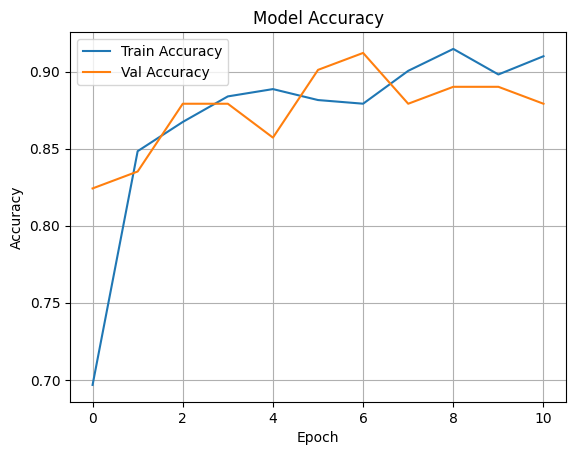

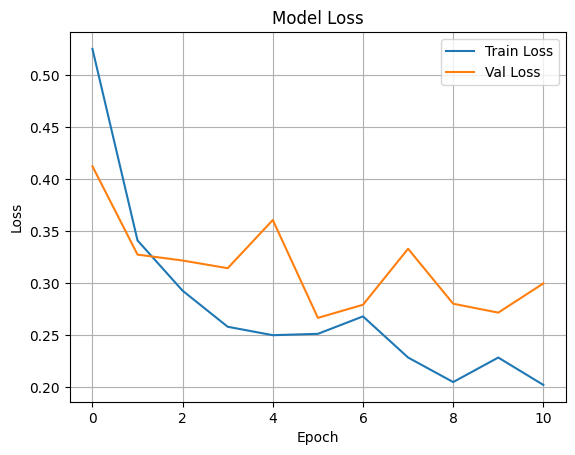

In [15]:
# CNN 1D for Depression Prediction
# Skema Eksperimen Model (Menggunakan Dataset Split)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Load Data Split ---
train_df = pd.read_csv("D:/ITERA/SEMESTER 8/cnn-modeling-ver2/dataset/train_data_70.csv")
val_df = pd.read_csv("D:/ITERA/SEMESTER 8/cnn-modeling-ver2/dataset/val_data_15.csv")
test_df = pd.read_csv("D:/ITERA/SEMESTER 8/cnn-modeling-ver2/dataset/test_data_15.csv")

# --- Pisahkan fitur dan label ---
X_train = train_df.drop("DEPRESSED", axis=1).values
y_train = train_df["DEPRESSED"].values

X_val = val_df.drop("DEPRESSED", axis=1).values
y_val = val_df["DEPRESSED"].values

X_test = test_df.drop("DEPRESSED", axis=1).values
y_test = test_df["DEPRESSED"].values

# --- Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Reshape untuk CNN 1D ---
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# --- Callback ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_ckpt = ModelCheckpoint("test/test-70.h5", save_best_only=True)

input_shape=(X_train_scaled.shape[1],1)

# --- Model CNN Baseline ---

# Kombinasi hyperparameter
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32, 64, 128]

# Fungsi membuat model
def create_baseline_model(learning_rate):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dictionary untuk menyimpan ringkasan hasil
results = {}

# Perulangan training semua kombinasi
for lr in learning_rates:
    for bs in batch_sizes:
        config_name = f"LR_{lr}_BS_{bs}"
        print(f"🚀 Training model: {config_name}")

        # Buat dan latih model
        model = create_baseline_model(learning_rate=lr)
        history = model.fit(X_train_scaled, y_train,
                            validation_data=(X_val_scaled, y_val),
                            epochs=50,
                            batch_size=bs,
                            callbacks=[early_stop],
                            verbose=0)

        # Simpan model ke file .h5
        model.save(f"D:/ITERA/SEMESTER 8/cnn-modeling-ver2/models/model_{config_name}.h5")

        # Simpan history ke file .json
        with open(f"D:/ITERA/SEMESTER 8/cnn-modeling-ver2/history/history_{config_name}.json", "w") as f:
            json.dump(history.history, f)

        # Simpan ringkasan
        results[config_name] = {
            'final_val_acc': history.history['val_accuracy'][-1],
            'final_val_loss': history.history['val_loss'][-1]
        }

# Tampilkan ringkasan semua eksperimen
print("\n📊 RINGKASAN HASIL:")
for config, res in results.items():
    print(f"{config} ➤ Val Acc: {res['final_val_acc']:.4f}, Val Loss: {res['final_val_loss']:.4f}")
# --- Confusion Matrix & Classification Report ---
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# --- Plotting ---
with open("test/test-70.json", 'r') as f:
    hist = json.load(f)

plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


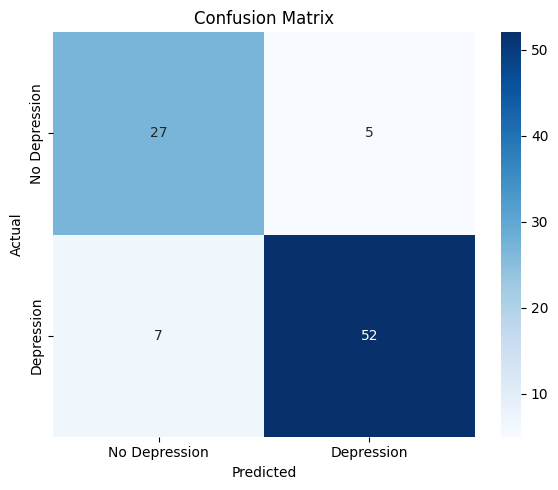

Classification Report:
               precision    recall  f1-score   support

           0     0.7941    0.8438    0.8182        32
           1     0.9123    0.8814    0.8966        59

    accuracy                         0.8681        91
   macro avg     0.8532    0.8626    0.8574        91
weighted avg     0.8707    0.8681    0.8690        91

Accuracy: 0.8681
Precision: 0.9123
Recall: 0.8814
F1 Score: 0.8966


In [16]:
# --- Confusion Matrix & Classification Report ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# --- Visualisasi Confusion Matrix ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Depression', 'Depression'], yticklabels=['No Depression', 'Depression'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# Classification report
cr = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", cr)

# Metrics manually if needed
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
